In [1]:
import os
import sys
import time

import itertools
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm as tqdm_auto
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import pytorch_lightning as pl

from IPython.display import clear_output

In [2]:
from simple_cnn import SimpleCNN

sys.path.append("../../predictor/model/")
import utrdata_cl as utrdata
from pl_regressor import RNARegressor

## Loading data

In [3]:
PATH_FROM = "../../regression_multiple/UTR3_zscores_replicateagg.csv"
df = pd.read_csv(PATH_FROM)

In [4]:
num_classes = df["cell_type"].unique().shape[0]
num_classes

6

In [5]:
splits = dict(tuple(df.groupby('fold')))
for split_df in splits.values():
    split_df.reset_index(drop=True, inplace=True)
splits["val"].head()

,seq,cell_type,fold,1,2,3,4,mass_center,mass_center_mean,diff,zscore,mass_center_std
0,AAAAAAAGGATATAGCAAACCTAACTGATAACTTTGCTAGTTTCAA...,c1,val,6.002917,7.654993,8.144573,14.842668,2.868519,2.447925,0.420593,1.805402,0.232964
1,AAAAAAAGGATATAGCAAACCTAACTGATAACTTTGCTAGTTTCAA...,c13,val,37.271653,34.714706,30.423658,39.155814,2.504808,2.447925,0.056883,0.244173,0.232964
2,AAAAAAAGGATATAGCAAACCTAACTGATAACTTTGCTAGTTTCAA...,c17,val,60.550851,49.969473,28.877094,38.700174,2.256750,2.447925,-0.191175,-0.820621,0.232964
3,AAAAAAAGGATATAGCAAACCTAACTGATAACTTTGCTAGTTTCAA...,c2,val,36.093004,21.819718,25.572823,31.869453,2.461347,2.447925,0.013422,0.057615,0.232964
4,AAAAAAAGGATATAGCAAACCTAACTGATAACTTTGCTAGTTTCAA...,c4,val,47.512956,37.364773,37.069136,21.653372,2.228850,2.447925,-0.219075,-0.940382,0.232964


In [6]:
batch_size = 128
steps_per_epoch = max(1, splits["train"].shape[0] // batch_size)

# batch_per_epoch = 128  # None

# if batch_per_epoch is None:
#     # batch_per_epoch = int(np.ceil(splits["train"].shape[0] / batch_size))
#     batch_per_epoch = splits["train"].shape[0] // batch_size  # drop_last=True @ DataLoader

epochs = 20

In [7]:
num_workers = 32

In [8]:
def launch_model(
    seed: int,
    train_ds_kws: dict,
    val_ds_kws: dict,
    model_class,
    model_kws: dict,
    criterion_class,
    criterion_kws: dict,
    optimizer_class,
    optimizer_kws: dict,
    lr_scheduler_class,
    lr_scheduler_kws: dict,
    test_time_validation: bool,
    epochs: int = epochs,
):
    pl.seed_everything(seed)

    # Creating Datasets
    train_set = utrdata.UTRData(
        df=splits["train"],
        **train_ds_kws,
    )
    val_set = utrdata.UTRData(
        df=splits["val"],
        **val_ds_kws,
    )

    assert train_set.num_channels == val_set.num_channels
    try:
        div_factor = val_ds_kws["augment_kws"]["shift_left"] + \
                     val_ds_kws["augment_kws"]["shift_right"] + 1
    except KeyError:
        div_factor = 1

    # Creating DataLoaders
    dl_train = DataLoader(
        train_set,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True,
        drop_last=True
    )
    # dl_train = utrdata.DataLoaderWrapper(dl_train, batch_per_epoch=batch_per_epoch)
    dl_val = DataLoader(
        val_set,
        batch_size=batch_size // div_factor,
        num_workers=num_workers,
        shuffle=False,
        drop_last=False
    )

    model = RNARegressor(
        model_class=model_class,
        model_kws=model_kws | dict(
            in_channels=train_set.num_channels
        ),
        criterion_class=criterion_class,
        criterion_kws=criterion_kws,
        optimizer_class=optimizer_class,
        optimizer_kws=optimizer_kws,
        lr_scheduler_class=lr_scheduler_class,
        lr_scheduler_kws=lr_scheduler_kws,
        test_time_validation=test_time_validation,
    )
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath="saved_models",
        save_top_k=1,
        save_last=False,
        monitor="val_pearson_r_0",
        mode="max"
    )
    progressbar_callback = pl.callbacks.TQDMProgressBar(refresh_rate=0.5)

    logger = pl.loggers.tensorboard.TensorBoardLogger("tb_logs", name=model.model_name)
    trainer = pl.Trainer(
        callbacks=[checkpoint_callback, progressbar_callback],
        logger=logger,
        accelerator="gpu",
        devices=1,
        deterministic=True,
        max_epochs=epochs,
        num_sanity_val_steps=0,
        # gradient_clip_val=1e-5,
        # gradient_clip_algorithm="norm",
    )
    trainer.fit(model=model, train_dataloaders=dl_train, val_dataloaders=dl_val)
    best_model = RNARegressor.load_from_checkpoint(checkpoint_callback.best_model_path)

    prediction = trainer.predict(model=best_model, dataloaders=dl_val)
    val_pred, val_real = zip(*prediction)
    val_pred = torch.concat(val_pred).numpy()
    val_real = torch.concat(val_real).numpy()
    val_df = splits["val"].copy()
    val_df["real_0"] = val_real[:, 0]
    val_df["pred_0"] = val_pred[:, 0]

    return trainer, val_df

In [9]:
checked = {
    "seed": [3],  # 3, 7, 13, 42, 100
    "features": [
        # ("sequence", "revcomp", "intensity", "positional", "conditions"),
        ("sequence", "conditions"),  # "positional",
    ],
    "augment_dict": [
        dict(
            extend_left=0,
            extend_right=0,
            shift_left=0,
            shift_right=0,
            revcomp=False,
        ),
    ],
    "epochs": [20],
    # "task_loss": [
    #     ("soft_classification", nn.CrossEntropyLoss),
    #     ("soft_regression", nn.MSELoss),
    #     ("regression", nn.MSELoss),
    # ]
}

for subset in itertools.product(
    *checked.values()
):
    PARAMS = dict(zip(checked.keys(), subset))
    AUGMENT_KEY = any(PARAMS["augment_dict"].values())
    AUGMENT_TEST_TIME = AUGMENT_KEY

    trainer_last, prediction_best_last = launch_model(
        seed=PARAMS["seed"],
        train_ds_kws=dict(
            predict_cols=["mass_center"],
            construct_type="utr3",
            features=PARAMS["features"],  # ("sequence", "conditions", "positional", "revcomp")
            augment=AUGMENT_KEY,
            augment_test_time=False,
            augment_kws=PARAMS["augment_dict"],
        ),
        val_ds_kws=dict(
            predict_cols=["mass_center"],
            construct_type="utr3",
            features=PARAMS["features"],  # ("sequence", "conditions", "positional", "revcomp")
            augment=False,
            augment_test_time=AUGMENT_TEST_TIME,
            augment_kws=PARAMS["augment_dict"],
        ),
        model_class=SimpleCNN,
        model_kws=dict(
            seqsize=240,
            in_channels=4,  # IS REPLACED
            ks=8,
            out_channels=1,
            conv_sizes=(120, 120, 120),
            dropouts=(0, 0, 0.2),
            linear_size=40,
            final_activation=nn.Identity
        ),
        criterion_class=nn.MSELoss,
        criterion_kws=dict(),
        optimizer_class=torch.optim.AdamW,
        optimizer_kws=dict(
            lr=0.001,
            betas=(0.9, 0.999),
            eps=1e-08,
            weight_decay=0.1,
        ),
        lr_scheduler_class=None,
        lr_scheduler_kws=dict(),
        # lr_scheduler_class=torch.optim.lr_scheduler.OneCycleLR,
        # lr_scheduler_kws=dict(
        #     max_lr=0.001,
        #     steps_per_epoch=steps_per_epoch,
        #     epochs=PARAMS["epochs"],
        #     pct_start=0.3,
        #     three_phase=False,
        #     cycle_momentum=True,
        # ),
        test_time_validation=AUGMENT_TEST_TIME,
        epochs=PARAMS["epochs"],
    )

Global seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/arsen_l/.miniconda3/envs/ml/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/arsen_l/rna-legnet/wp4_benchmarks_figures/rna-legnet/benchmark/cnn/saved_models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type      | Params
----------------------------------------
0 | 

Training: 0it [00:00, ?it/s]

/home/arsen_l/.miniconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

## Launching model

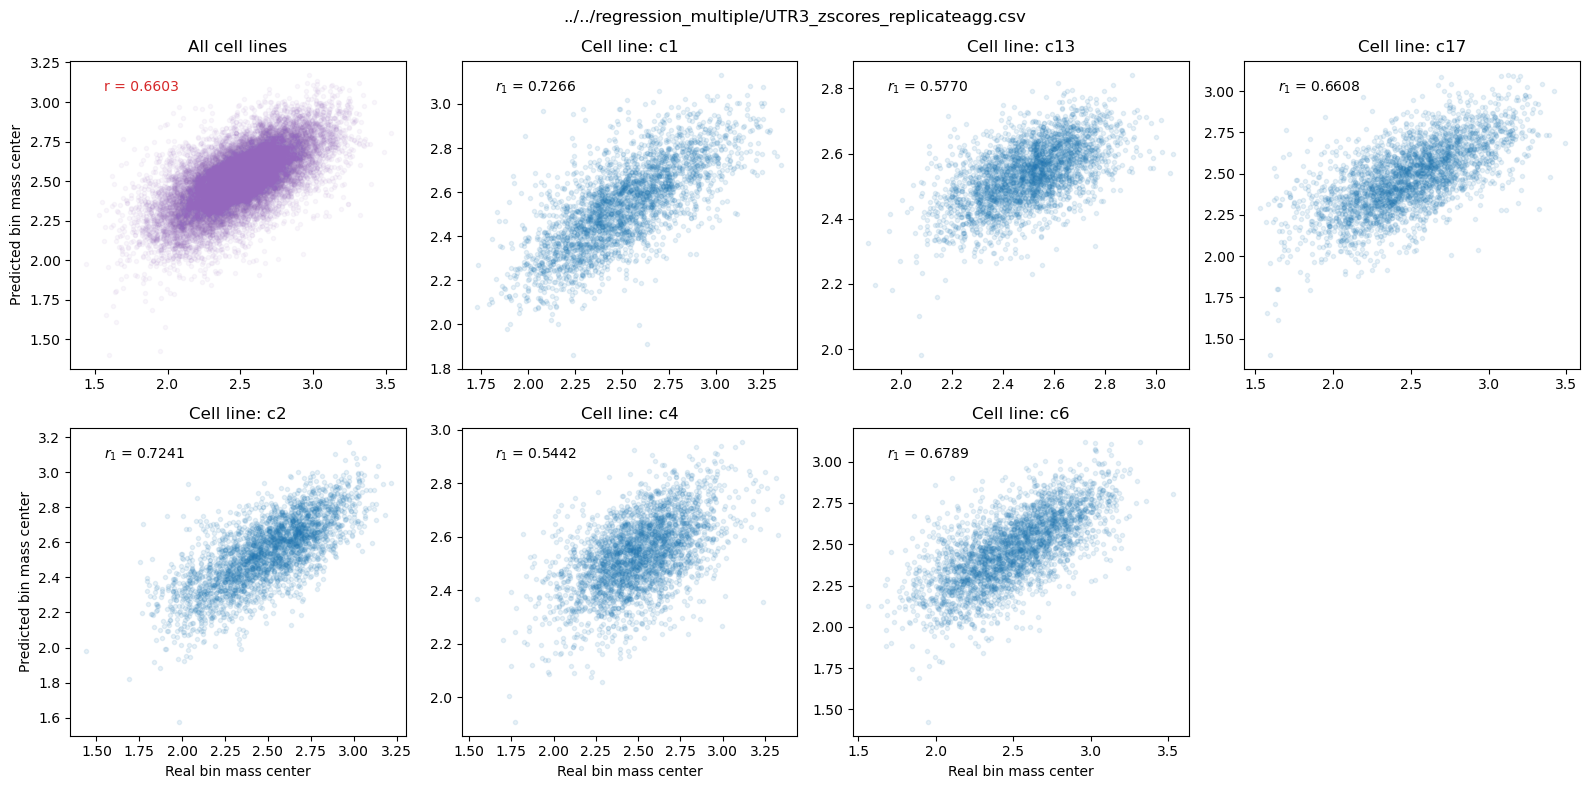

In [10]:
plt.figure(figsize=(16, 8))

rows = 2
cols = 4

x = "mass_center"
y = "pred_0"

ax = plt.subplot(rows, cols, 1)
r = ss.pearsonr(prediction_best_last[x], prediction_best_last[y]).statistic
plt.scatter(prediction_best_last[x], prediction_best_last[y], color="C4", marker=".", alpha=0.05)
plt.text(0.1, 0.9, f"r = {r:.04f}", color="C3", transform=ax.transAxes)
plt.title("All cell lines")
plt.ylabel("Predicted bin mass center")

for i, (ct, ctdf) in enumerate(prediction_best_last.groupby(by="cell_type"), 2):
    r = ss.pearsonr(ctdf[x], ctdf[y]).statistic
    ax = plt.subplot(rows, cols, i)
    plt.scatter(ctdf[x], ctdf[y], color="C0", marker=".", alpha=0.1)
    plt.text(0.1, 0.9, f"$r_1$ = {r:.04f}", transform=ax.transAxes)
    plt.title(f"Cell line: {ct}")
    if (i - 1) // cols == rows - 1:
        plt.xlabel("Real bin mass center")
    if i % cols == 1:
        plt.ylabel("Predicted bin mass center")
plt.tight_layout()

plt.suptitle(PATH_FROM)
plt.tight_layout()
plt.show()

---